In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Load the dataset, skipping the first 5 lines of metadata
df = pd.read_csv('2015_ALL_YEAR=2025.csv', skiprows=5)

# Select relevant columns with exact names (including trailing spaces)
df = df[['Date', 'Time', 'PRCP.H-1 (in) ', 'SMS.I-1:-2 (pct)  (loam)', 'TOBS.I-1 (degC) ']]

# Rename for simplicity
df = df.rename(columns={
    'PRCP.H-1 (in) ': 'Precipitation',
    'SMS.I-1:-2 (pct)  (loam)': 'Soil_Moisture_2in',
    'TOBS.I-1 (degC) ': 'Air_Temperature'
})

# Create datetime column and set as index
df['Datetime'] = pd.to_datetime(df['Date'] + ' ' + df['Time'])
df = df.set_index('Datetime')
df = df.drop(['Date', 'Time'], axis=1)

# Identify invalid values (-99.9) and convert to NaN
df.replace(-99.9, np.nan, inplace=True)

# Count missing (NaN) and invalid (already converted to NaN) values
missing_counts = df.isna().sum()
print("Number of missing/invalid values per column:")
print(missing_counts)
print("\nPercentage of missing/invalid values per column:")
print((missing_counts / len(df)) * 100)

# Resample to daily for visualization (count NaNs per day)
daily_missing = df.isna().resample('D').sum()

Number of missing/invalid values per column:
Precipitation        0
Soil_Moisture_2in    0
Air_Temperature      0
dtype: int64

Percentage of missing/invalid values per column:
Precipitation        0.0
Soil_Moisture_2in    0.0
Air_Temperature      0.0
dtype: float64


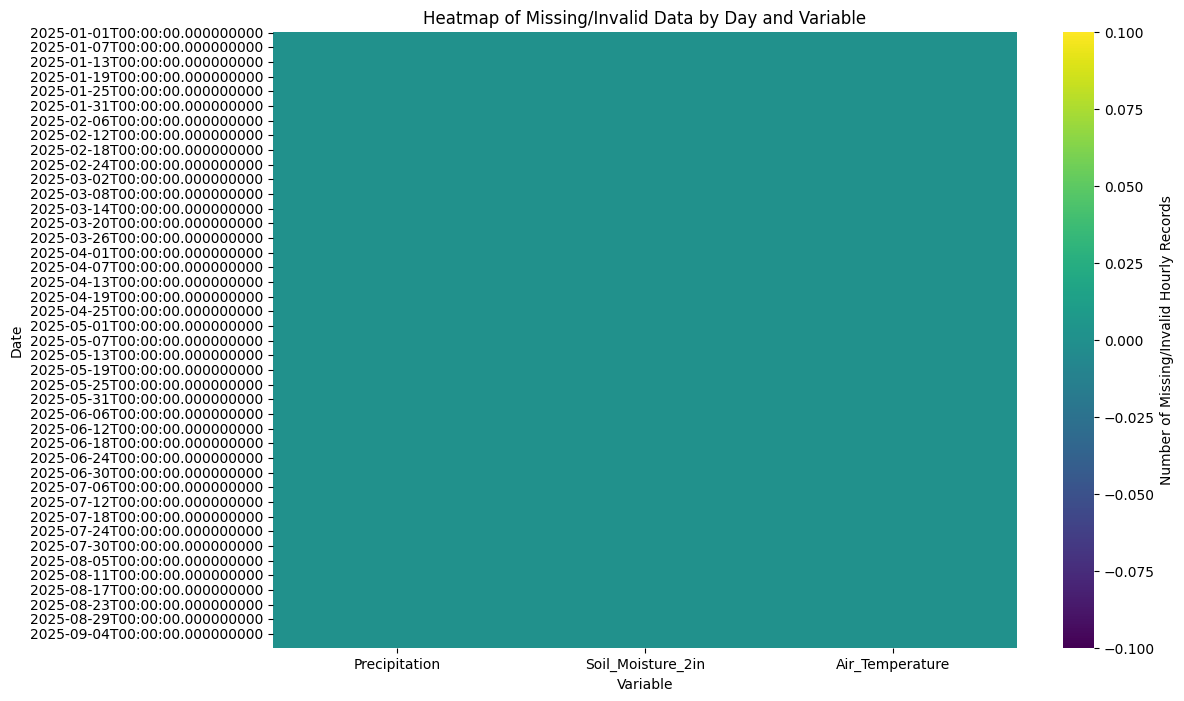

In [17]:
# Create heatmap of missing/invalid data
plt.figure(figsize=(12, 8))
sns.heatmap(daily_missing, cmap='viridis', cbar_kws={'label': 'Number of Missing/Invalid Hourly Records'})
plt.title('Heatmap of Missing/Invalid Data by Day and Variable')
plt.xlabel('Variable')
plt.ylabel('Date')
plt.show()

In [ ]:
# Handle missing values (forward fill for continuity)
df = df.fillna(method='ffill').dropna()

# Resample to daily for clearer trends
daily_df = df.resample('D').agg({
    'Precipitation': 'sum',  # Daily total precip
    'Soil_Moisture_2in': 'mean',  # Daily avg soil moisture
    'Air_Temperature': 'mean'  # Daily avg temp
})

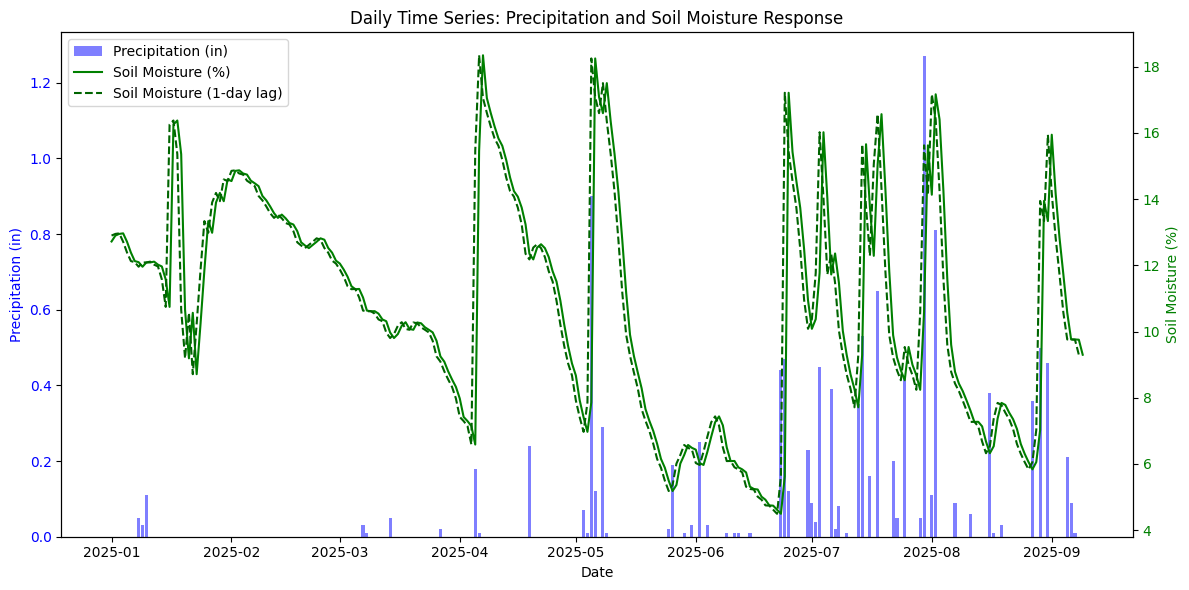

In [11]:
# Create figure with dual axes
fig, ax1 = plt.subplots(figsize=(12, 6))

# Plot precipitation as bars on left axis
ax1.bar(daily_df.index, daily_df['Precipitation'], color='blue', alpha=0.5, label='Precipitation (in)')
ax1.set_xlabel('Date')
ax1.set_ylabel('Precipitation (in)', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')

# Create second axis for soil moisture
ax2 = ax1.twinx()
ax2.plot(daily_df.index, daily_df['Soil_Moisture_2in'], color='green', label='Soil Moisture (%)')
ax2.set_ylabel('Soil Moisture (%)', color='green')
ax2.tick_params(axis='y', labelcolor='green')

# Add lagged soil moisture (1-day shift to show response 'after')
daily_df['Soil_Moisture_Lagged'] = daily_df['Soil_Moisture_2in'].shift(-1)
ax2.plot(daily_df.index, daily_df['Soil_Moisture_Lagged'], color='darkgreen', linestyle='--', label='Soil Moisture (1-day lag)')

# Add titles and legend
plt.title('Daily Time Series: Precipitation and Soil Moisture Response')
fig.tight_layout()
handles1, labels1 = ax1.get_legend_handles_labels()
handles2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(handles1 + handles2, labels1 + labels2, loc='upper left')
plt.show()

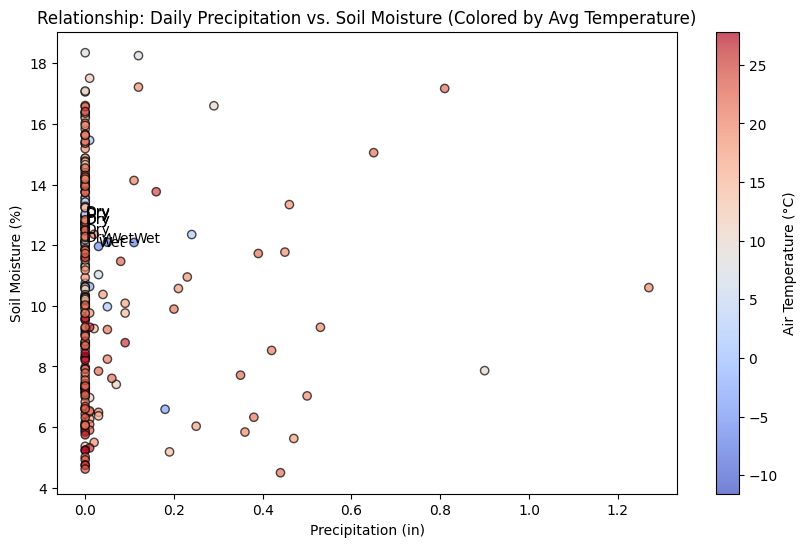

Correlation between Precipitation and Soil Moisture: -0.05
Lagged Correlation (Precip vs. Next-Day Moisture Change): 0.56


In [12]:
# Infer weather status
daily_df['Weather_Status'] = 'Dry'
daily_df.loc[daily_df['Precipitation'] > 0, 'Weather_Status'] = 'Wet'
daily_df.loc[(daily_df['Air_Temperature'] > 26.7) & (daily_df['Precipitation'] == 0), 'Weather_Status'] = 'Hot/Dry'

# Scatter plot: Precipitation vs. Soil Moisture, colored by temperature
plt.figure(figsize=(10, 6))
scatter = plt.scatter(daily_df['Precipitation'], daily_df['Soil_Moisture_2in'], 
                      c=daily_df['Air_Temperature'], cmap='coolwarm', alpha=0.7, edgecolor='k')
plt.colorbar(scatter, label='Air Temperature (°C)')
plt.xlabel('Precipitation (in)')
plt.ylabel('Soil Moisture (%)')
plt.title('Relationship: Daily Precipitation vs. Soil Moisture (Colored by Avg Temperature)')

# Annotate status for a subset to avoid clutter
for i in daily_df.index[:10]:
    plt.annotate(daily_df.loc[i, 'Weather_Status'], 
                 (daily_df.loc[i, 'Precipitation'], daily_df.loc[i, 'Soil_Moisture_2in']))

plt.show()

# Compute correlations
correlation = daily_df['Precipitation'].corr(daily_df['Soil_Moisture_2in'])
print(f"Correlation between Precipitation and Soil Moisture: {correlation:.2f}")

# Lagged correlation for 'after' effect
daily_df['Moisture_Change'] = daily_df['Soil_Moisture_2in'].diff()
lagged_corr = daily_df['Precipitation'].corr(daily_df['Moisture_Change'].shift(-1))
print(f"Lagged Correlation (Precip vs. Next-Day Moisture Change): {lagged_corr:.2f}")